In [1]:
!pip install ipdb
!pip install matrix_completion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 2.0.10
    Uninstalling prompt-toolkit-2.0.10:
      Successfully uninstalled prompt-toolkit-2.0.10
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.8.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, htt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matrix_completion import svt_solve, calc_unobserved_rmse, nuclear_norm_solve
import ipdb
import logging
import random
import scipy
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import autoreload
import time
from cvxpy import *
import seaborn as sns

logging.basicConfig(level=logging.INFO)
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.metrics.pairwise import rbf_kernel

In [4]:
sns.set_style('darkgrid')

In [5]:
sys.path.append("./utils/")

In [8]:
from utils_objective import compute_bp_gain
from baselines_class import *
from environment_class import *
from ek_bp_ucb_class import *
from ek_separate import *

In [339]:
#Configurations for the script
_users_range = 900
_movie_range = 1600
_T = 100

# Controls how quickly the submodular regularization plateaus off
# In a practical application, this would be a really important hyperparameter
_lambda_one = 2
_lambda_two = 5

# For matrix completion
_mu = 1e-3

#The variance of the noise in the rewards during the algorithm
_sigma = 1

# For the Laplacian non-sparsification
_decay_rate = 5
_num_meta_users = 10

#For the tradeoff between the cosine, jaccard and linear kernel when designing the composite kernel
_k1 = 1/3
_k2 = 1/3
_k3 = 1/3

# KORS configurations
mu_kors = 1
lambda_kors = 1
epsilon_kors = 0.5


_beta_lst = [20 for i in range(_T)]

## Load Data

First I load the dataframes

In [11]:
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

Below, I extract the users that are most represented in the data. This will improve the quality of matrix completion and the ratings matrix that I am using.

In [12]:
selected_users_gb = ratings_df.groupby('userId').size().sort_values(ascending=False)[:_users_range]
selected_users_lst = selected_users_gb.index.tolist()

In [13]:
selected_users_gb

userId
72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
116518     1507
22574      1506
117524     1505
29358      1505
7561       1505
Length: 900, dtype: int64

In [14]:
ratings_smaller_df = ratings_df[ratings_df['userId'].isin(selected_users_lst)] 

Now, I select the movies that are most represented for this selection of users.

In [15]:
dense_range = int(_movie_range*1)
selected_movies_dense = ratings_smaller_df.groupby('movieId').size().sort_values(ascending=False)[:dense_range].index.tolist()
selected_movies_lst = selected_movies_dense

In [16]:
ratings_df_s = ratings_smaller_df[ratings_smaller_df['movieId'].isin(selected_movies_lst)] 

In [17]:
movies_df_s = movies_df[movies_df["movieId"].isin(selected_movies_lst)]

Create the ratings matrix

In [18]:
user_to_row = dict((e, idx) for (idx, e) in enumerate(selected_users_lst))

In [19]:
movie_to_column = dict((e, idx) for (idx, e) in enumerate(selected_movies_lst))

In [20]:
column_to_movie = dict(enumerate(selected_movies_lst))

In [21]:
M = np.empty((_users_range, _movie_range))
mask = np.zeros((_users_range, _movie_range))

M[:] = 0

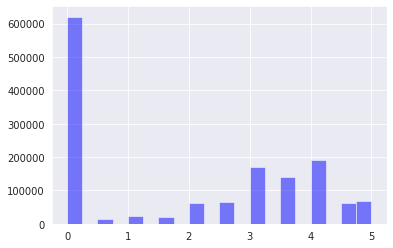

In [22]:
for idx, row in ratings_df_s.iterrows():
        user_id, movie_id, rating = int(row["userId"]), int(row["movieId"]), row["rating"]
        row, column = user_to_row[user_id], movie_to_column[movie_id]
        M[row, column] = rating
        mask[row, column] = 1

n,bins,patches = plt.hist(np.ravel(M),20,facecolor='blue',alpha=0.5); 
plt.show()

In [23]:
#Sparsity ratio
np.sum(mask)/mask.size

0.56895625

In [24]:
M[:, 1]

array([4. , 4. , 4. , 5. , 5. , 4.5, 5. , 2. , 3. , 4. , 5. , 0. , 4. ,
       4.5, 3.5, 4. , 3. , 3.5, 4. , 5. , 4. , 4. , 4. , 4.5, 5. , 4. ,
       4. , 3.5, 4. , 5. , 5. , 4. , 3. , 3.5, 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 3.5, 5. , 4.5, 4.5, 4.5, 5. , 4.5, 2. , 4.5, 4. ,
       4. , 4.5, 4.5, 5. , 4.5, 4. , 4. , 3.5, 4. , 5. , 5. , 4. , 4. ,
       5. , 4.5, 2. , 1.5, 5. , 5. , 3.5, 3. , 3. , 4.5, 4. , 4. , 4. ,
       5. , 3.5, 3. , 3.5, 5. , 3.5, 4.5, 4.5, 4.5, 5. , 4.5, 4.5, 5. ,
       5. , 4. , 3.5, 4.5, 4.5, 4.5, 4. , 5. , 5. , 4.5, 4. , 4. , 4. ,
       4.5, 3. , 4.5, 5. , 5. , 2.5, 3. , 1.5, 5. , 2.5, 3. , 4. , 5. ,
       4.5, 4.5, 5. , 5. , 5. , 5. , 5. , 2. , 4.5, 5. , 4. , 3.5, 4. ,
       4. , 4. , 3.5, 3. , 3. , 4. , 4.5, 5. , 4.5, 4. , 4. , 4.5, 4. ,
       5. , 3. , 5. , 4. , 3. , 5. , 5. , 5. , 5. , 4.5, 5. , 5. , 3. ,
       4.5, 4.5, 2.5, 3.5, 5. , 5. , 5. , 4.5, 4.5, 5. , 4. , 5. , 4. ,
       3.5, 4. , 5. , 4.5, 5. , 5. , 3. , 5. , 4.5, 0. , 4.5, 4.

## Use SVD to impute missing values: Semi-synthetic aspect

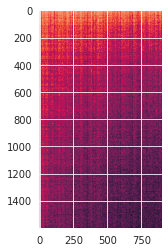

In [25]:
plt.imshow(M.T)

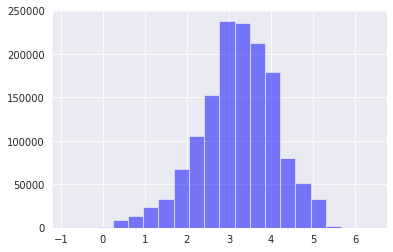

In [30]:
n,bins,patches = plt.hist(np.ravel(M_filled),20,facecolor='blue',alpha=0.5); 
plt.show()

In [31]:
overflow_right_idx = M_filled > 5
overflow_left_idx = M_filled < 0

M_filled[overflow_right_idx] = 5
M_filled[overflow_left_idx] = 0

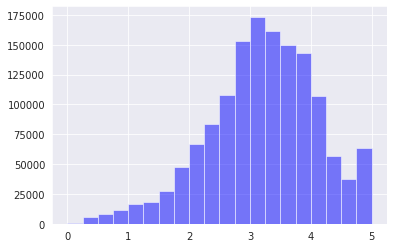

In [32]:
n,bins,patches = plt.hist(np.ravel(M_filled),20,facecolor='blue',alpha=0.5); 
plt.show()

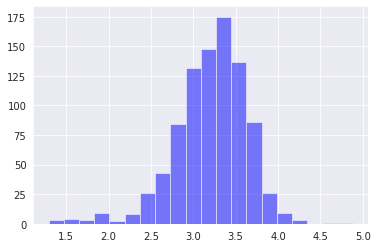

In [33]:
np.mean(M_filled, axis = 0)
plt.hist(np.mean(M_filled, axis = 1),20,facecolor='blue',alpha=0.5); 

# Perform KMeans on Users

In [34]:
kmeans = KMeans(n_clusters=_num_meta_users, random_state=0).fit(M_filled)
cluster_centers = kmeans.cluster_centers_
user_labels = kmeans.labels_

In [35]:
user_labels

array([3, 6, 3, 9, 0, 9, 3, 2, 7, 9, 5, 5, 1, 1, 2, 2, 4, 2, 8, 7, 1, 9,
       1, 0, 3, 7, 9, 1, 6, 8, 3, 1, 1, 1, 9, 6, 1, 1, 0, 7, 6, 4, 7, 3,
       8, 6, 9, 3, 6, 7, 1, 1, 9, 3, 3, 9, 1, 9, 6, 9, 1, 8, 1, 6, 3, 1,
       9, 7, 3, 9, 9, 4, 3, 9, 8, 9, 9, 1, 0, 7, 4, 2, 2, 9, 6, 8, 6, 0,
       2, 3, 5, 6, 1, 8, 6, 6, 6, 9, 6, 1, 6, 2, 7, 1, 6, 1, 6, 3, 3, 7,
       9, 7, 0, 2, 2, 8, 0, 6, 6, 3, 6, 3, 4, 9, 7, 9, 6, 6, 9, 1, 9, 1,
       9, 2, 1, 9, 0, 9, 7, 5, 8, 9, 1, 9, 9, 6, 6, 9, 1, 5, 6, 9, 3, 3,
       0, 1, 1, 8, 1, 9, 3, 6, 8, 9, 1, 9, 3, 6, 1, 3, 1, 7, 8, 8, 1, 9,
       6, 0, 1, 9, 9, 3, 0, 9, 0, 1, 6, 1, 9, 7, 8, 1, 3, 2, 1, 2, 7, 9,
       6, 9, 6, 9, 9, 1, 1, 9, 9, 3, 6, 0, 1, 1, 8, 8, 2, 1, 8, 8, 6, 7,
       1, 7, 3, 0, 1, 6, 2, 7, 8, 2, 7, 1, 2, 6, 8, 9, 9, 6, 9, 7, 7, 9,
       2, 9, 2, 3, 8, 7, 3, 9, 7, 1, 9, 1, 1, 7, 3, 6, 3, 0, 9, 4, 6, 7,
       8, 7, 1, 0, 3, 9, 2, 3, 9, 6, 3, 3, 6, 0, 9, 8, 7, 1, 1, 9, 8, 2,
       6, 2, 9, 7, 9, 7, 7, 3, 1, 9, 9, 3, 1, 7, 1,

In [36]:
pca = PCA(n_components=2)
pca.fit(M_filled)

PCA(n_components=2)

In [37]:
users_projected = pca.transform(M_filled)
centers_projected = pca.transform(cluster_centers)

In [38]:
centers_projected.shape

(10, 2)

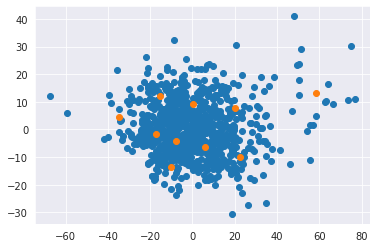

In [39]:
plt.scatter(users_projected[:, 0], users_projected[:, 1])
plt.scatter(centers_projected[:, 0], centers_projected[:, 1])

In [40]:
kmeans_movies = KMeans(n_clusters=10, random_state=0).fit(M_filled.T)
cluster_centers_movies = kmeans_movies.cluster_centers_
pca_movies = PCA(n_components=2)
pca_movies.fit(M_filled.T)
movies_projected = pca_movies.transform(M_filled.T)
centers_projected = pca_movies.transform(cluster_centers_movies)

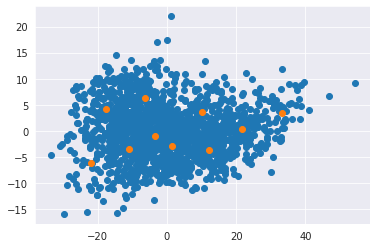

In [41]:
plt.scatter(movies_projected[:, 0], movies_projected[:, 1])
plt.scatter(centers_projected[:, 0], centers_projected[:, 1])

# Run all algorithms

### Run Algorithm 

In [42]:
genre_set = set()

for movie in range(_movie_range):
    movie_genres = find_genres(movie, column_to_movie, movies_df_s)
    genre_set = genre_set.union(movie_genres)

genre_list = list(genre_set)

In [43]:
genre_list

['Children',
 'Film-Noir',
 'Musical',
 'Western',
 'Romance',
 'Thriller',
 'War',
 'Sci-Fi',
 'IMAX',
 'Fantasy',
 'Documentary',
 'Adventure',
 'Horror',
 'Action',
 'Mystery',
 'Animation',
 'Crime',
 'Drama',
 'Comedy']

In [44]:
movie_similarity_mat = rbf_kernel(M_filled.T, M_filled.T, gamma = 1/_users_range)

'\nmovie_similarity_mat = np.zeros((_movie_range, _movie_range))\n\nfor i in range(_movie_range):\n    if i % 100 == 0:\n        print(i)\n    for j in range(i+1):\n\n        first_features = M_filled[:, i].reshape(1, -1)\n        second_features = M_filled[:, j].reshape(1, -1)\n\n        score = rbf_kernel(first_features, second_features)\n        movie_similarity_mat[i,j] = score\n        movie_similarity_mat[j,i] = score\n'

In [45]:
affinity_mat = np.load("movie_similarity.npy")

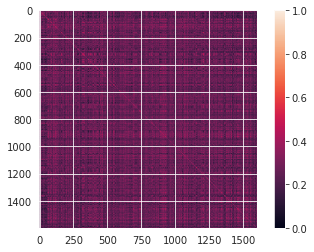

In [46]:
plt.imshow(affinity_mat)
plt.colorbar()

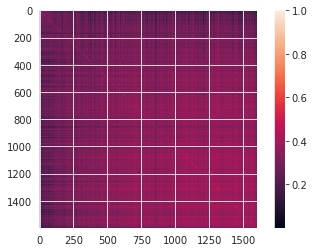

In [49]:
plt.imshow(movie_similarity_mat)
plt.colorbar()

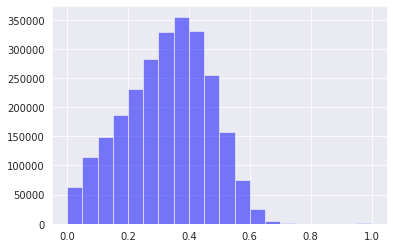

In [53]:
plt.hist(np.ravel(movie_similarity_mat),20,facecolor='blue',alpha=0.5);

In [54]:
ground_set = np.arange(_movie_range)

In [325]:
ret_random_lst, ret_bp_ucb_lst, ret_greedy_lst, ret_naive_ucb_lst, ret_distorted_lst = [], [], [], [], []

In [364]:
for i in range(8, 10):   
    
  ## Random ####

  print("############ RANDOM ##################")

  random_rec = RandomBaseline(ground_set, genre_list, affinity_mat, 
                              column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels)

  env_random = Environment(_T, _sigma, genre_list, _lambda_one, _lambda_two, 
                    affinity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, random_rec, seed = i)

  ret_random = env_random.run_simulation()
  ret_random_lst.append(ret_random)


  print("############### DISTORTED UCB ####################")
  np.random.seed(i)
  ui_lst = np.random.choice(len(cluster_centers), size = _T)

  k1 = 0.3
  k2 = 0.3
  k3 = 0.3
  k4 = 0.1

  ek_ucb_rec_sep = EK_BP_UCB_Sep(ground_set, _beta_lst, _sigma, genre_list, k1, k2, k3, k4, movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, lambda_kors, mu_kors, epsilon_kors, ui_lst)

  env_ek_ucb_sep = Environment(_T,  _sigma, genre_list, _lambda_one, _lambda_two, 
                      movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, ek_ucb_rec_sep, seed = i, ui_lst = ui_lst)
  
  ret_ucb_sep = env_ek_ucb_sep.run_simulation()

  ret_distorted_lst.append(ret_ucb_sep)


  print("############### UCB ####################")

  ### UCB ###

  ek_ucb_rec = EK_BP_UCB(ground_set,_beta_lst, _sigma, genre_list, _k1, _k2, _k3, movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, lambda_kors, mu_kors, epsilon_kors)

  env_ek_ucb = Environment(_T,  _sigma, genre_list, _lambda_one, _lambda_two, 
                    movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, ek_ucb_rec, seed = i)

  ret_ucb = env_ek_ucb.run_simulation()
  ret_bp_ucb_lst.append(ret_ucb)



  # print("############### GREEDY ####################")

  # ### GREEDY ####

  # greedy_rec = GreedyBaseline(ground_set, column_to_movie, movies_df_s, M_filled, affinity_mat, user_labels, _lambda_one, _lambda_two, _num_meta_users)

  # env_greedy = Environment(_T,  _sigma, genre_list, _lambda_one, _lambda_two, 
  #                   affinity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, greedy_rec, seed = i)

  # ret_greedy = env_greedy.run_simulation()
  # ret_greedy_lst.append(ret_greedy)

  print("############### NAIVE SUBMODULAR ####################")

  ### NAIVE SUBMODULAR ###

  _beta_lst_sm = [7 for i in range(_T)]

  ek_naive_sm_ucb_rec = EK_BP_UCB(ground_set,_beta_lst_sm, _sigma, genre_list, _k1, _k2, _k3, movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, lambda_kors, mu_kors, epsilon_kors)

  env_naive_sm_ucb = Environment(_T,  _sigma, genre_list, _lambda_one, _lambda_two, 
                    movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, ek_naive_sm_ucb_rec, naive_submodular_flag = True, seed = i)

  ret_naive_sm_ucb = env_naive_sm_ucb.run_simulation()
  ret_naive_ucb_lst.append(ret_naive_sm_ucb)



Streaming output truncated to the last 5000 lines.
3494     3593  Battlefield Earth (2000)  Action|Sci-Fi


User identity at iteration 75 is: 6
      movieId                  title  genres
2946     3039  Trading Places (1983)  Comedy


User identity at iteration 76 is: 1
       movieId             title         genres
11966    56145  Mist, The (2007)  Horror|Sci-Fi


User identity at iteration 77 is: 4
      movieId             title        genres
3014     3107  Backdraft (1991)  Action|Drama


User identity at iteration 78 is: 8
     movieId             title                genres
148      150  Apollo 13 (1995)  Adventure|Drama|IMAX


User identity at iteration 79 is: 7
      movieId                title  genres
3875     3979  Little Nicky (2000)  Comedy


User identity at iteration 80 is: 3
      movieId                  title             genres
1978     2067  Doctor Zhivago (1965)  Drama|Romance|War


User identity at iteration 81 is: 3
      movieId                  title          

In [382]:
ret_bp_ucb_mat = np.zeros((5, 100))

for i in range(5):
  ret_bp_ucb_mat[i, :] = ret_bp_ucb_lst[i][2]

In [383]:
ret_sm_ucb_mat = np.zeros((5, 100))

for i in range(5):
  ret_sm_ucb_mat[i, :] = ret_naive_ucb_lst[i][2]


In [384]:
ret_random_mat = np.zeros((5, 100))
for i in range(5):
    ret_random_mat[i, :] = ret_random_lst[i][2]

In [377]:
ret_distorted_mat = np.zeros((10, 100))
for i in range(10):
    ret_distorted_mat[i, :] = ret_distorted_lst[i][2]

In [385]:
bpucb_rewards_cumsum = np.array([np.cumsum(ret_bp_ucb_mat[i]) for i in range(5)])
smucb_rewards_cumsum = np.array([np.cumsum(ret_sm_ucb_mat[i])for i in range(5)])
random_rewards_cumsum = np.array([np.cumsum(ret_random_mat[i])for i in range(5)])
sep_rewards_cumsum = np.array([np.cumsum(ret_distorted_mat[i])for i in range(10)])

In [386]:
greedy_mean = np.mean(greedy_rewards_cumsum, axis = 0)
bpucb_mean = np.mean(bpucb_rewards_cumsum, axis = 0)
smucb_mean = np.mean(smucb_rewards_cumsum, axis = 0)
random_mean = np.mean(random_rewards_cumsum, axis = 0)
sep_mean = np.mean(sep_rewards_cumsum, axis = 0)

In [388]:
bpucb_low = bpucb_mean - np.std(bpucb_rewards_cumsum, axis = 0)
bpucb_high =  bpucb_mean + np.std(bpucb_rewards_cumsum, axis = 0)

smucb_low = smucb_mean - np.std(smucb_rewards_cumsum, axis = 0)
smucb_high = smucb_mean + np.std(smucb_rewards_cumsum, axis = 0)

random_low = random_mean - np.std(random_rewards_cumsum, axis = 0)
random_high = random_mean + np.std(random_rewards_cumsum, axis = 0)

sep_low = sep_mean - np.std(sep_rewards_cumsum, axis = 0)
sep_high = sep_mean + np.std(sep_rewards_cumsum, axis = 0)


In [389]:
font = {'family' : 'normal',
        'size'   : 13,
        'weight': 'bold'
        }

plt.rc('font', **font)

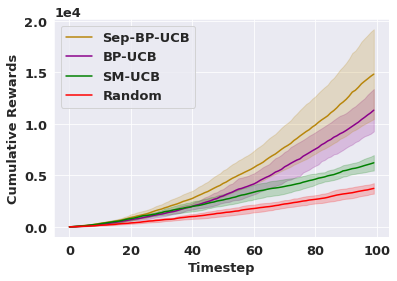

In [390]:

plt.plot(sep_mean, label = 'Sep-BP-UCB', color = 'darkgoldenrod')
plt.plot(bpucb_mean, label = 'BP-UCB', color = 'darkmagenta')
plt.plot(smucb_mean, label = 'SM-UCB', color = 'green')
plt.plot(random_mean, label = 'Random', color = 'red')


plt.fill_between(np.arange(100), bpucb_low, bpucb_high, color = 'darkmagenta', alpha = 0.2)
plt.fill_between(np.arange(100), sep_low, sep_high, color = 'darkgoldenrod', alpha = 0.2)
plt.fill_between(np.arange(100), smucb_low, smucb_high, color = 'green', alpha = 0.2)
plt.fill_between(np.arange(100), random_low, random_high, color = 'red', alpha = 0.2)

plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Timestep", weight = 'bold')
plt.ylabel("Cumulative Rewards", weight = 'bold')
plt.savefig("baseline_plot_final", format = 'pdf', bbox_inches = "tight")